In [1]:
import ROOT
import PyRDF
import json
import pandas as pd
from copy import deepcopy

ROOT.gROOT.Macro('../setStyle.C')
ROOT.gROOT.LoadMacro('../FPCanvasStyle.C')
#ROOT.gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')

Welcome to JupyROOT 6.18/00


0

In [2]:
nC = 1
def makeROOTCanvas(histos=[], size=None, npads=(1, 1), drawopt=''):
    """
    Helper function. Create ROOT TCanvas and draw all the provide histograms. 
    Note that the draw option should be specified using SetDrawOption before passing
    the histograms to this function.
    """
    global nC
    
    ###---Create the canvas
    # default 
    if not size:
        c = ROOT.TCanvas('plot_%s'%nC)
    # custom splitting
    elif isinstance(size, tuple):
        c = ROOT.TCanvas('plot_%s'%nC, '', size[0], size[1])
    # All plots on the same line    
    else:
        c = ROOT.TCanvas('plot_%s'%nC, '', size, int(size/len(histos)))
        npads = (len(histos), 1)
    
    nx, ny = npads
    ###---Multiple sub-pads
    if nx>1 or ny>1:
        c.Divide(nx, ny)        
        for i,h in enumerate(histos):
            c.cd(i+1)
            h.Draw(drawopt[i] if isinstance(drawopt, list) else drawopt)
            ROOT.FPCanvasStyle(c.GetPad(i+1), "", "", 0, "", 0, 'COLZ' in h.GetDrawOption())
    ###---Single pad
    else:
        histos.Draw()
        ROOT.FPCanvasStyle(c, "", "", 0, "", 0, 'COLZ' in histos.GetDrawOption())
        
    nC = nC+1    
    return c    

In [3]:
runlist = pd.read_csv('data/energyscans18deg.csv', header=None, names=['run', 'energy', 'position', 'table_x', 'table_y', 'n_events'])
energies = ['50', '100', '150', '200', '250']
h4dfs = {}
h4t_list = {}
for E in energies:
    ###---Load trees using a TChain. Note RDataFrame accept a list of files too but doesn't deal with friend trees properly in that case, hence the workaround below
    h4t_list[E] = {}
    for run in runlist.loc[(runlist['position'].str.contains('C3')) & (abs(runlist['energy']-float(E))<10), 'run']:
        if E == '150' and int(run)>13499:
            continue
        f = ROOT.TFile.Open('/eos/user/s/spigazzi/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v8/ECAL_H4_October2018_%d.root' % run)
        if f:
            if len(h4t_list[E])==0:
                h4t_list[E]['h4'] = ROOT.TChain('h4')
                for ft in f.Get("h4").GetListOfFriends():
                    h4t_list[E][ft.GetName()] = ROOT.TChain(ft.GetName())
                    h4t_list[E]['h4'].AddFriend(h4t_list[E][ft.GetName()])
            for name, t in h4t_list[E].items():
                t.Add('/eos/user/s/spigazzi/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v8/ECAL_H4_October2018_%d.root' % run)
            f.Close()
    
    channels_3x3 = ['B2', 'B3', 'B4',
                    'C2', 'C3', 'C4',
                    'D2', 'D3', 'D4']
    ch_x_pos = {
        'A' : -2,
        'B' : -1,
        'C' : 0,
        'D' : 1,
        'E' : 2
    }
 
    ch_y_pos = {
        '1' : -2,
        '2' : -1,
        '3' : 0,
        '4' : 1,
        '5' : 2
    }
    
    h4dfs[E] = ROOT.RDataFrame(h4t_list[E]['h4'])
    h4dfs[E] = h4dfs[E].Filter('n_tracks==1 && fabs(X[0]+5)<5 && fabs(Y[0]-4)< 5 && fit_ampl[MCP1]>100 && fit_ampl[MCP2]>100 && fabs(fit_time[MCP1]-fit_time[MCP2]-4.5)<1.5')
    for ch in ['MCP1', 'MCP2', 'VFE_CLK', 
               'A1', 'A2', 'A3',
               'B1', 'B2', 'B3', 'B4', 'B5',
               'C1', 'C2', 'C3', 'C4', 'C5',
               'D1', 'D2', 'D3', 'D4', 'D5',
               'E1', 'E2', 'E3']:
        h4dfs[E] = h4dfs[E].Define('time_%s'%ch, 'fit_time[%s]+time_calib[%s]'%(ch,ch))
        if ch not in ['MCP1', 'MCP2', 'VFE_CLK']:        
            h4dfs[E] = h4dfs[E].Define('ampl_%s'%ch, 'fit_ampl[%s]*ampl_calib[%s]'%(ch,ch))    
            h4dfs[E] = h4dfs[E].Define('dt_mcp1_%s'%ch, 'time_%s-time_MCP1+time_VFE_CLK-int((time_%s-time_MCP1+time_VFE_CLK)/6.238)*6.238'%(ch,ch))
            h4dfs[E] = h4dfs[E].Define('dt_mcp2_%s'%ch, 'time_%s-time_MCP2+time_VFE_CLK-int((time_%s-time_MCP2+time_VFE_CLK)/6.238)*6.238'%(ch,ch))
            h4dfs[E] = h4dfs[E].Define('ecal_r_%s'%ch, 'sqrt(pow(ecal_x-(%d*22), 2) + pow(ecal_y-(%d*22), 2))'%(ch_x_pos[ch[0]], ch_y_pos[ch[1]]))
            if ch != 'C3':
                if 'C' in ch:
                    distance = 'fabs(ecal_y - (%d))' % (ch_y_pos[ch[1]]*11)
                elif '3' in ch:
                    distance = 'fabs(ecal_x - (%d))' % (ch_x_pos[ch[0]]*11)
                else:
                    distance = 'sqrt(pow(ecal_x - (%d), 2)+pow(ecal_y - (%d), 2))' % (ch_x_pos[ch[0]]*11, ch_y_pos[ch[1]]*11)
            else:
                distance = 'ecal_r_%s' % ch
            h4dfs[E] = h4dfs[E].Define('shower_%s_dist'%ch, distance)
        else:
            ###---For the MCPs we need A/sigmaN as amplitude
            h4dfs[E] = h4dfs[E].Define('norm_ampl_%s'%ch, 'fit_ampl[%s]/b_rms[%s]'%(ch,ch))    

    h4dfs[E] = h4dfs[E].Define('ampl_seed', 'fit_ampl[seed]*ampl_calib[seed]')    
    h4dfs[E] = h4dfs[E].Define('time_seed', 'fit_time[seed]-time_calib[seed]')    
    h4dfs[E] = h4dfs[E].Define('dt_mcp1_seed', 'time_seed-time_MCP1+time_VFE_CLK-int((time_seed-time_MCP1+time_VFE_CLK)/6.238)*6.238')
    h4dfs[E] = h4dfs[E].Define('dt_mcp2_seed', 'time_seed-time_MCP2+time_VFE_CLK-int((time_seed-time_MCP2+time_VFE_CLK)/6.238)*6.238')
    h4dfs[E] = h4dfs[E].Define('trk_x', 'X[0]')
    h4dfs[E] = h4dfs[E].Define('trk_y', 'Y[0]')
     

Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available


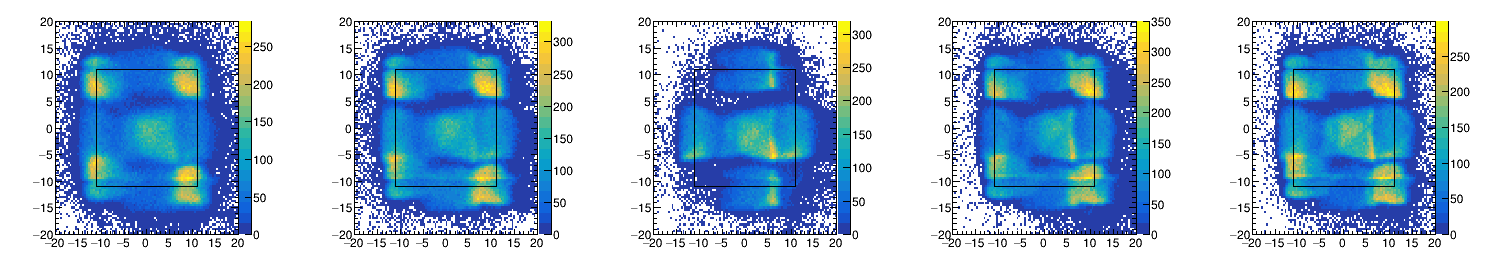

In [4]:
map_pos_allevts = {}
for i, E in enumerate(energies):
    map_pos_allevts[E] = h4dfs[E].Histo2D(("map_pos_allevts_%s"%E,"",100,-20,20,100,-20,20), 'ecal_x', 'ecal_y')

c = makeROOTCanvas(histos=map_pos_allevts.values(), size=1500, drawopt='COLZ')
for i in range(len(energies)):
    c.cd(i+1)
    c3bounds = ROOT.TLine()
    c3bounds.DrawLine(-11,-11,-11,11)
    c3bounds.DrawLine(-11,11,11,11)
    c3bounds.DrawLine(11,11,11,-11)
    c3bounds.DrawLine(11,-11,-11,-11)

c.Draw()

In [5]:
ROOT.gInterpreter.Declare("""
    double GetWeight(TObject* h, double x, double y)
    {
        TH2* histo = (TH2*)h;
        return histo->GetBinContent(histo->FindBin(x, y))>10 ? 1./histo->GetBinContent(histo->FindBin(x, y)) : 0.;
    }
    """)

selected_evts = {}
map_pos_selevts = {}
h2_dt_vs_dist = {}
pr_dt_vs_dist = {}

for E in energies:
    h2_dt_vs_dist[E] = {}
    pr_dt_vs_dist[E] = {}
    
    selected_evts[E] = h4dfs[E].Filter('seed==C3 && fabs(ecal_x)<11 && fabs(ecal_y)<11')
    map_pos_selevts[E] = selected_evts[E].Histo2D(('map_pos_selevts_%s'%E, '', 100, -20, 20, 100, -20, 20), 'ecal_x', 'ecal_y')
    selected_evts[E] = selected_evts[E].Define('weight', 'GetWeight(gDirectory->Get("map_pos_allevts_%s"), ecal_x, ecal_y)'%E)

    fcb = ROOT.TF1("fcb", "gaus", 0, 3)
    fcb.SetParameters(100, 1.3, 0.03, 20, 0.1)

    for ch in channels_3x3:
        h2_dt_vs_dist[E][ch] = selected_evts[E].Filter('ampl_%s>10'%(ch)).Histo2D(('h2_dt_vs_dist_%s_%s'%(ch, E), "", 35, 0, 35, 50, 0, 3), 'shower_%s_dist'%ch, 'dt_mcp2_%s'%ch)

    for ch, h in h2_dt_vs_dist[E].items():
        h.FitSlicesY(fcb)
        pr_dt_vs_dist[E][ch] = deepcopy(ROOT.gDirectory.Get('h2_dt_vs_dist_%s_%s_1'%(ch, E)))

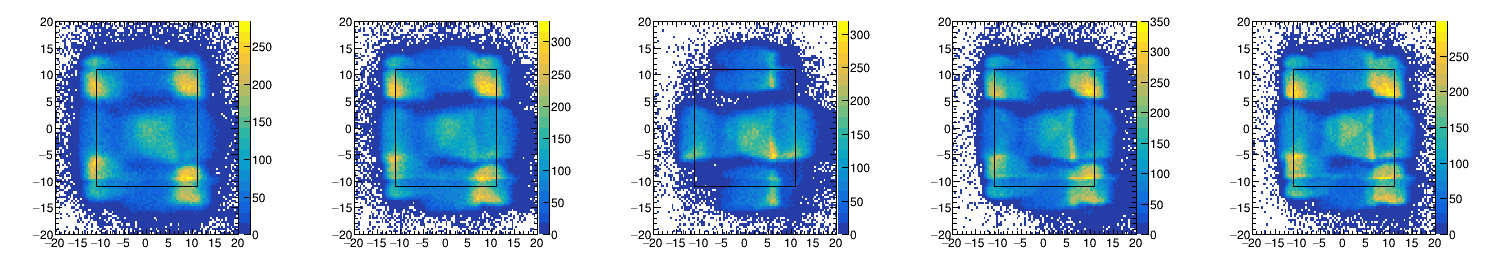

In [6]:
for i, E in enumerate(energies):
    scale = 1./map_pos_selevts[E].GetMaximum()
    map_pos_selevts[E].Scale(scale)
    map_pos_selevts[E].SetDrawOption("COLZ")
    
c = makeROOTCanvas(histos=map_pos_allevts.values(), size=1500, drawopt='COLZ')        
for i in range(len(energies)):
    c.cd(i+1)
    c3bounds = ROOT.TLine()
    c3bounds.DrawLine(-11,-11,-11,11)
    c3bounds.DrawLine(-11,11,11,11)
    c3bounds.DrawLine(11,11,11,-11)
    c3bounds.DrawLine(11,-11,-11,-11)

c.Draw()

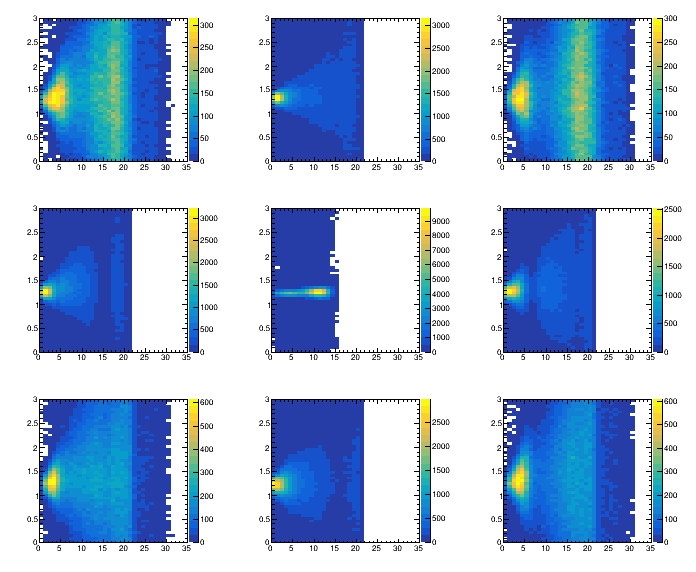

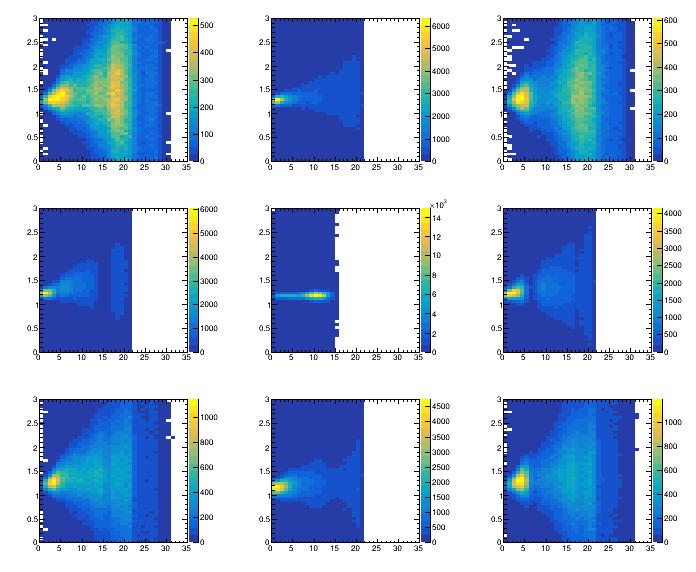

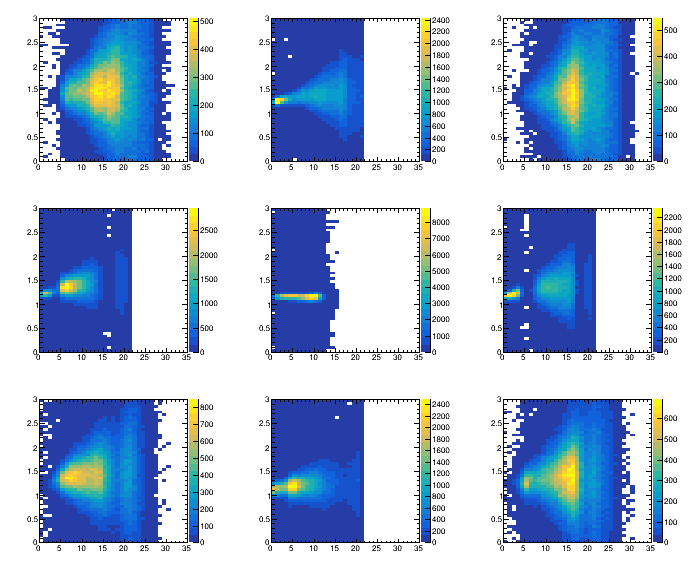

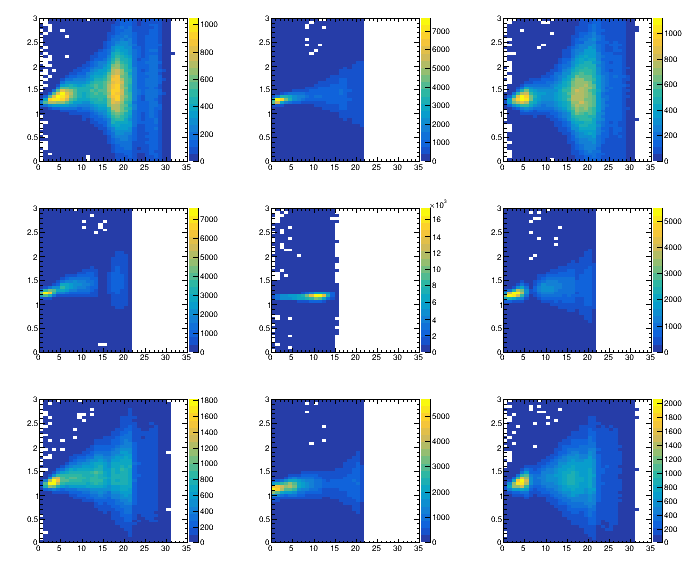

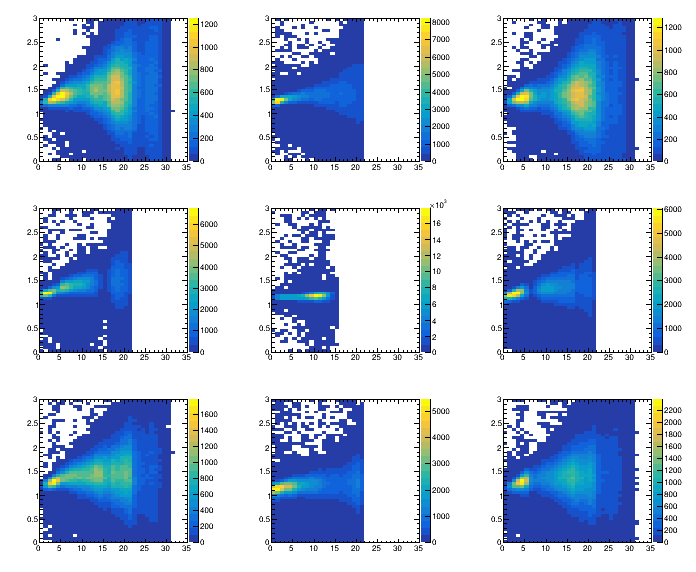

In [7]:
avg_dt_vs_dist = {}
c = {}
for E in energies:
    avg_dt_vs_dist[E] = ROOT.TH2D("avg_dt_vs_dist", "", 35, 0, 35, 50, 0, 3)
    avg_dt_vs_dist[E].Sumw2()
    for ch, h in h2_dt_vs_dist[E].items():
        h.SetDrawOption('COLZ')
        if ch not in ['C3', 'D3']:
            avg_dt_vs_dist[E].Add(avg_dt_vs_dist[E], h.GetValue())

    c[E] = makeROOTCanvas(h2_dt_vs_dist[E].values(), npads=(3,3), drawopt='COLZ')
    c[E].Draw()

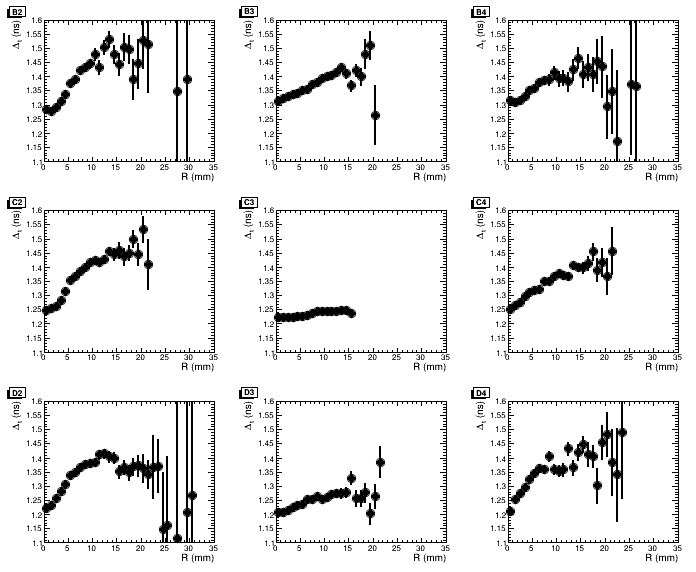

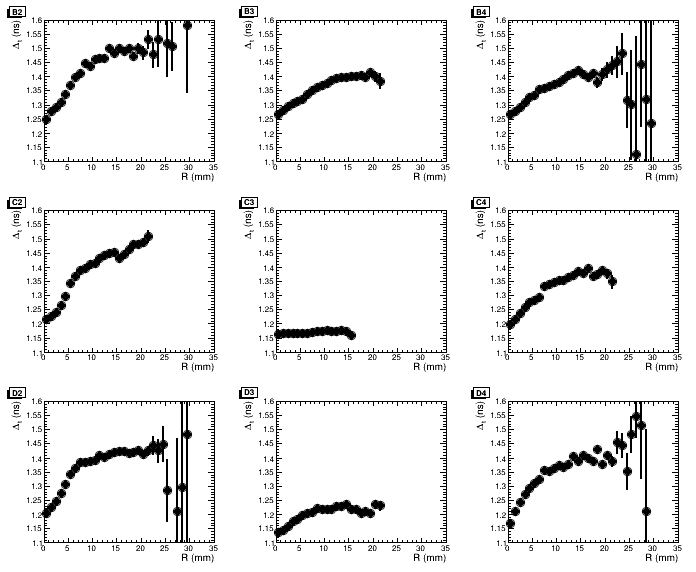

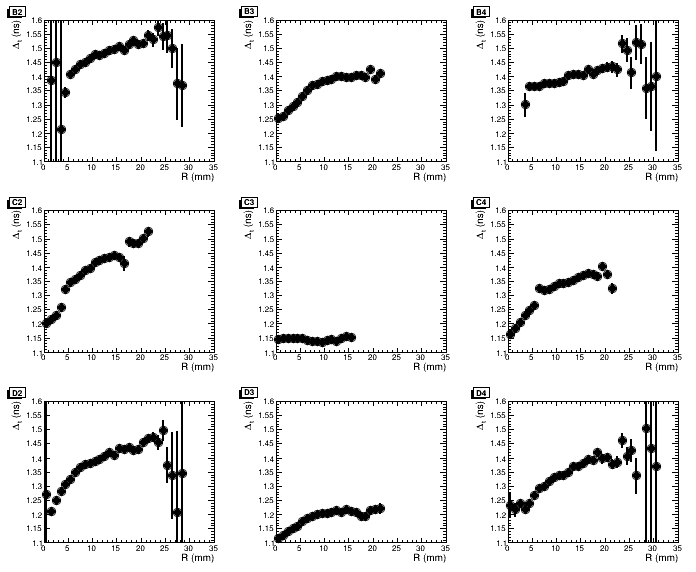

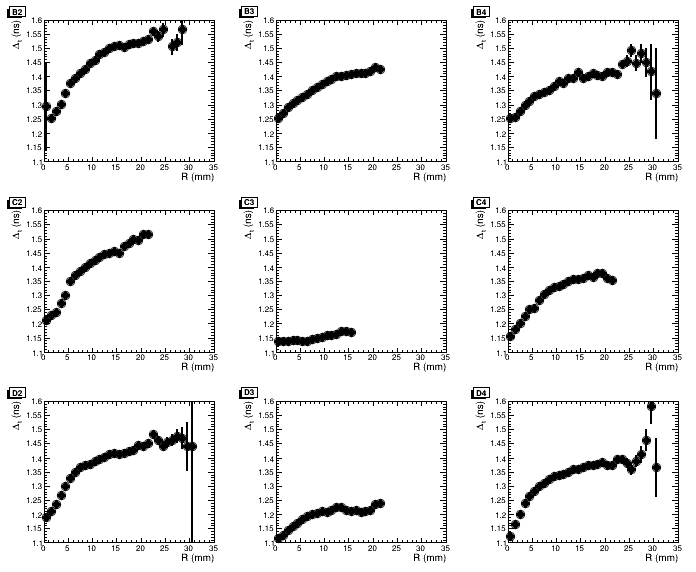

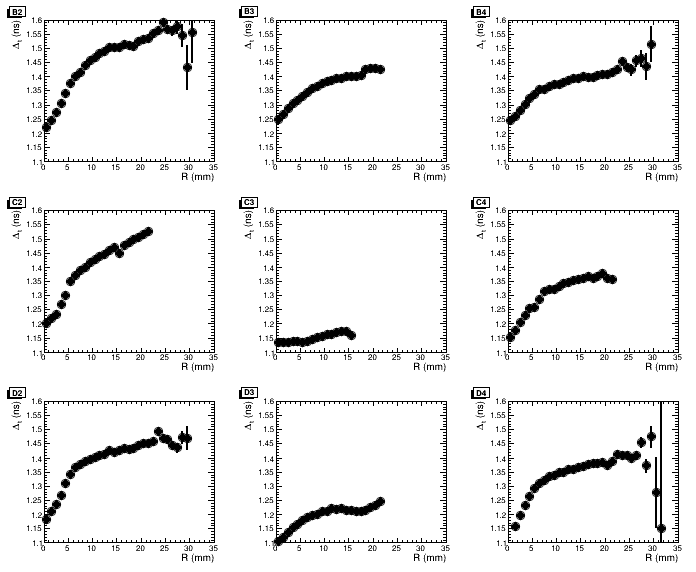

In [8]:
c = {}
for E in energies:
    for ch, pr in pr_dt_vs_dist[E].items():
        pr.SetTitle('%s;R (mm);#Delta_{t} (ns)'%ch)
        pr.GetYaxis().SetRangeUser(1.1, 1.6)

    c[E] = makeROOTCanvas(pr_dt_vs_dist[E].values(), npads=(3,3))
    c[E].Draw()

 FCN=633.93 FROM MIGRAD    STATUS=CONVERGED     313 CALLS         314 TOTAL
                     EDM=9.06107e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.18424e-01   7.21776e-03   1.91881e-06   1.29579e+00
   2  p1          -9.23525e+00   5.16603e-01   2.93281e-04  -2.17379e-03
   3  p2           7.60387e-01   2.74187e-02   5.06219e-06   3.77689e-01
 FCN=720.806 FROM MIGRAD    STATUS=CONVERGED     268 CALLS         269 TOTAL
                     EDM=9.82972e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.59360e-01   2.72380e-03   1.81445e-06   2.77926e+00
   2  p1          -4.46955e+00   1.74038e-01   2.25449e-04  -1.71369e-02
   3  p2           9.62337e-01   9

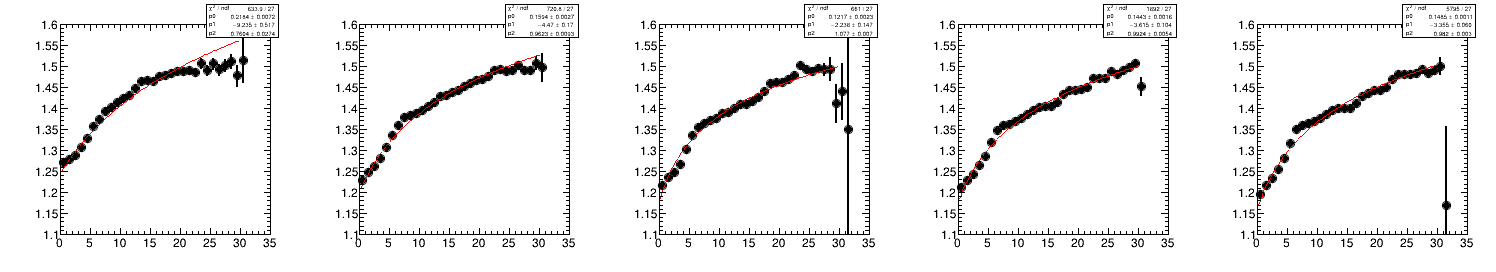

In [9]:
avg_pr_dt_vs_dist = {}
for E in energies:
    #avg_dt_vs_dist[E].FitSlicesY(fcb)
    #pr_dt_vs_dist[E] = deepcopy(ROOT.gDirectory.Get('avg_dt_vs_dist_1'))
    avg_pr_dt_vs_dist[E] = avg_dt_vs_dist[E].ProfileX()
    avg_pr_dt_vs_dist[E].SetName('pr_dt_vs_dist_%s'%E)
    avg_pr_dt_vs_dist[E].GetYaxis().SetRangeUser(1.1, 1.6)
    corr_func = ROOT.TF1("corr_func", "[0]*log(x-[1])+[2]", 0, 40)
    corr_func.SetParameters(1., 1., 1.25)
    avg_pr_dt_vs_dist[E].Fit(corr_func, "R", "", 0, 30)

c = makeROOTCanvas(histos=avg_pr_dt_vs_dist.values(), size=1500)    
c.Draw()

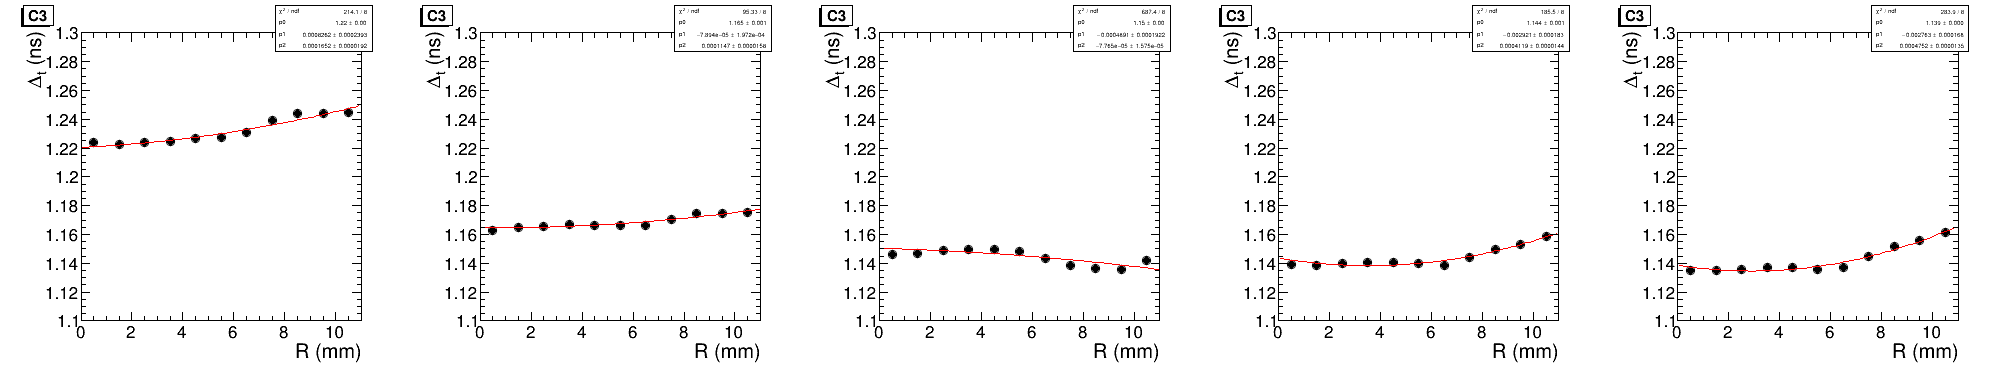

In [10]:
for E in energies:
     pr_dt_vs_dist[E]['C3'].GetXaxis().SetRangeUser(0, 11)
     pr_dt_vs_dist[E]['C3'].GetYaxis().SetRangeUser(1.1, 1.3)   
     pr_dt_vs_dist[E]['C3'].Fit("pol2", "RQ", "", 0, 11)   

c = makeROOTCanvas(histos=[pr['C3'] for pr in pr_dt_vs_dist.values()], size=2000)    
c.Draw()

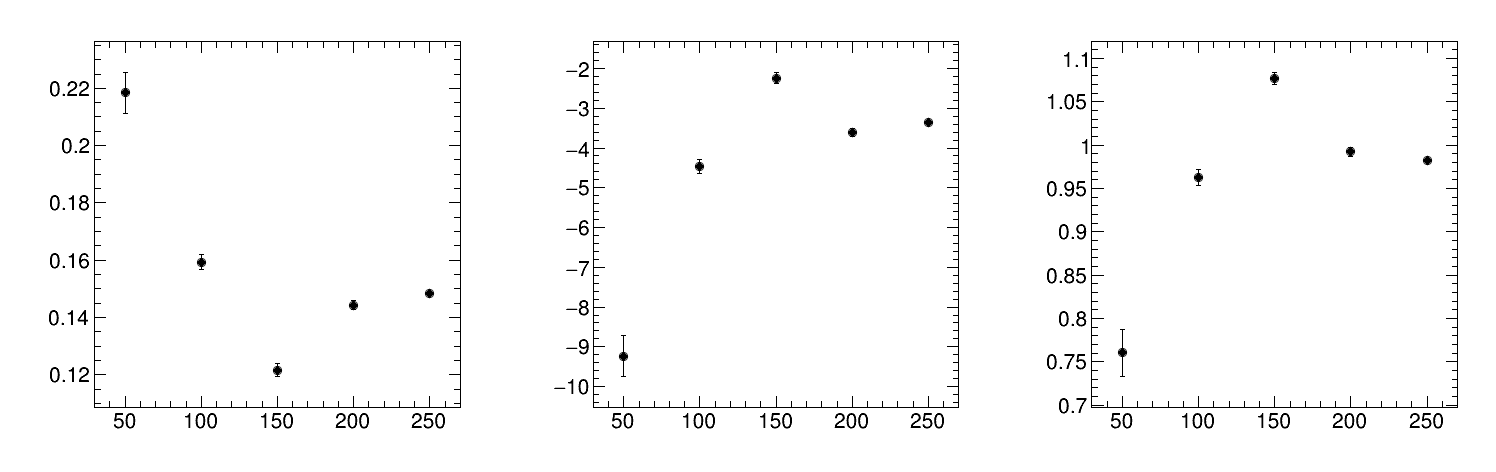

In [11]:
gr = []
for par in [0, 1, 2]:
    gr.append(ROOT.TGraphErrors())
    for i, E in enumerate(energies):
        gr[par].SetPoint(i, float(E), avg_pr_dt_vs_dist[E].GetFunction("corr_func").GetParameter(par))
        gr[par].SetPointError(i, 0., avg_pr_dt_vs_dist[E].GetFunction("corr_func").GetParError(par))
    
c = makeROOTCanvas(histos=gr, size=1500, drawopt='AP')
c.Draw()

In [12]:
ROOT.gInterpreter.Declare("""
    double SingleCrystalTimeResolution(double x, double n=1.07332e+04, double c=20.)
    {
        return sqrt(n*n/(x*x) + c*c);
    };
    double EcalTimeAverage(vector<double> times, vector<double> amplitudes)
    {
        double time=0., sumw=0.;
        for(int i=0; i<times.size(); ++i)         
        {
            auto res = SingleCrystalTimeResolution(amplitudes[i]/5.)/1000.;
            time += times[i]/res/res;
            sumw += 1./res/res;                        
        }
        
        return time/sumw;
    };
    """)

avg_pr_dt_vs_dist['250'].SetDirectory(ROOT.gDirectory)

for E in energies:
    times_mcp1_str = ''
    times_mcp2_str = ''    
    ampls_str = ''
    for ch in channels_3x3:
        if ch != 'C3':
            times_mcp1_str += 'corrected_dt_mcp1_%s, '%ch
            times_mcp2_str += 'corrected_dt_mcp2_%s, '%ch            
            ampls_str += 'ampl_%s, '%ch
            selected_evts[E] = selected_evts[E].Define('corrected_time_%s'%ch, 
                                                      'fit_time[%s]+time_calib[%s]-((TH1*)gDirectory->Get("pr_dt_vs_dist_250"))->GetFunction("corr_func")->Eval(shower_%s_dist)+((TH1*)gDirectory->Get("pr_dt_vs_dist_250"))->GetFunction("corr_func")->Eval(0)'%(ch, ch, ch))            
            selected_evts[E] = selected_evts[E].Define('corrected_dt_mcp1_%s'%ch, 'corrected_time_%s-time_MCP1+time_VFE_CLK-int((corrected_time_%s-time_MCP1+time_VFE_CLK)/6.238)*6.238'%(ch,ch))            
            selected_evts[E] = selected_evts[E].Define('corrected_dt_mcp2_%s'%ch, 'corrected_time_%s-time_MCP2+time_VFE_CLK-int((corrected_time_%s-time_MCP2+time_VFE_CLK)/6.238)*6.238'%(ch,ch))
        else:
            times_mcp1_str += 'dt_mcp1_%s, '%ch
            times_mcp2_str += 'dt_mcp2_%s, '%ch            
            ampls_str += 'ampl_%s, '%ch

    parameters_mcp1_str = '{'+times_mcp1_str[:-2]+'},{'+ampls_str[:-2]+'}'
    parameters_mcp2_str = '{'+times_mcp2_str[:-2]+'},{'+ampls_str[:-2]+'}'    
    selected_evts[E] = selected_evts[E].Define('dt_mcp1_ECAL', 'EcalTimeAverage(%s)'%parameters_mcp1_str)
    selected_evts[E] = selected_evts[E].Define('dt_mcp2_ECAL', 'EcalTimeAverage(%s)'%parameters_mcp2_str)    

In [13]:
h_weights = {}
h_dt_mcp1_ecal = {}
h_dt_mcp1_seed = {}
h_dt_mcp2_ecal = {}
h_dt_mcp2_seed = {}
dt_map_ecal = {}
dt_map_seed = {}
dict_dt_mcp1_seed = {}
dict_dt_mcp2_seed = {}
dict_dt_mcp1_ecal = {}
dict_dt_mcp2_ecal = {}
dict_dt_mcps = {}
dict_ampl_seed = {}
dict_ampl_ecal = {}    
dict_ampl_mcp1 = {}
dict_ampl_mcp2 = {}
dict_weights = {}

for E in energies:    
    #dt_mcp1_ECAL>2.2 && dt_mcp1_ECAL<2.8 && dt_mcp2_ECAL>2.2 && dt_mcp2_ECAL<2.8
    selected_evts[E] = selected_evts[E].Filter('dt_mcp1_seed>2.2 && dt_mcp1_seed<2.8 && dt_mcp1_ECAL>2.2 && dt_mcp1_ECAL<2.8 && dt_mcp2_seed>0.9 && dt_mcp2_seed<1.5 && dt_mcp2_ECAL>0.9 && dt_mcp2_ECAL<1.5')    
    h_weights[E] = selected_evts[E].Histo1D('weight')
    h_dt_mcp1_ecal[E] = selected_evts[E].Histo1D(("h_ecal_mcp1_%s"%E,"",100,2.2,2.8), 'dt_mcp1_ECAL', 'weight')
    h_dt_mcp1_seed[E] = selected_evts[E].Histo1D(("h_seed_mcp1_%s"%E,"",100,2.2,2.8), 'dt_mcp1_seed', 'weight')
    h_dt_mcp2_ecal[E] = selected_evts[E].Histo1D(("h_ecal_mcp2_%s"%E,"",100,0.9,1.5), 'dt_mcp2_ECAL', 'weight')
    h_dt_mcp2_seed[E] = selected_evts[E].Histo1D(("h_seed_mcp2_%s"%E,"",100,0.9,1.5), 'dt_mcp2_seed', 'weight')
    dt_map_ecal[E] = selected_evts[E].Histo3D(("dt_map_ecal_%s"%E,"",8,-11,11,8,-11,11,100,0.9,1.5), 'ecal_x', 'ecal_y', 'dt_mcp2_ECAL')
    dt_map_seed[E] = selected_evts[E].Histo3D(("dt_map_seed_%s"%E,"",8,-11,11,8,-11,11,100,0.9,1.5), 'ecal_x', 'ecal_y', 'dt_mcp2_seed')    
    dict_dt_mcp1_seed[E] = selected_evts[E].Take('double')('dt_mcp1_seed')
    dict_dt_mcp2_seed[E] = selected_evts[E].Take('double')('dt_mcp2_seed')
    dict_dt_mcp1_ecal[E] = selected_evts[E].Take('double')('dt_mcp1_ECAL')
    dict_dt_mcp2_ecal[E] = selected_evts[E].Take('double')('dt_mcp2_ECAL')
    dict_dt_mcps[E] = selected_evts[E].Define('dt_mcps', 'time_MCP1-time_MCP2').Take('float')('dt_mcps')
    dict_ampl_seed[E] = selected_evts[E].Take('float')('ampl_seed')
    dict_ampl_ecal[E] = selected_evts[E].Take('float')('e3x3')    
    dict_ampl_mcp1[E] = selected_evts[E].Take('float')('norm_ampl_MCP1')
    dict_ampl_mcp2[E] = selected_evts[E].Take('float')('norm_ampl_MCP2')
    dict_weights[E] = selected_evts[E].Take('double')('weight')

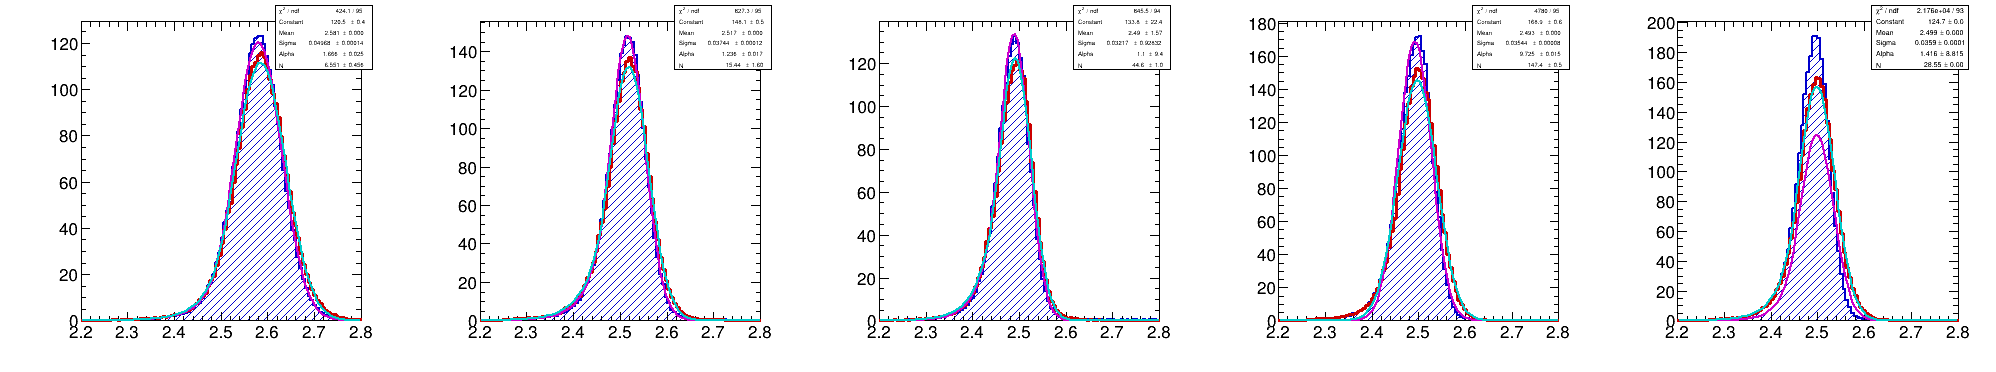

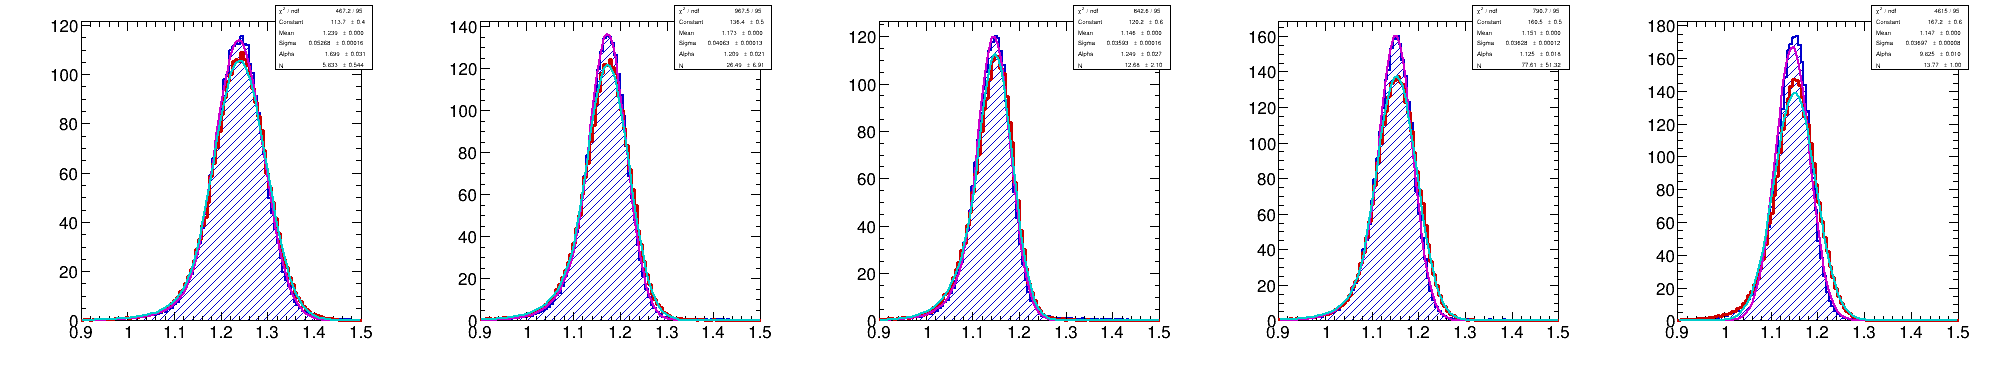

In [14]:
for i,E in enumerate(energies):
    map_pos_allevts[E].SetDirectory(ROOT.gDirectory)

    f_res_t = ROOT.TF1("f_res_t", "crystalball", 0, 3)
    f_res_t.SetParameters(100, 2.5, 0.03, 0.1, 1.)
    f_res_t.SetParLimits(1, 1., 2.7)
    f_res_t.SetParLimits(2, 0.02, 1.)
    f_res_t.SetParLimits(3, 0, 10)
    f_res_t.SetLineWidth(2)
    f_res_t.SetLineColor(ROOT.kMagenta+1)

    h_dt_mcp1_seed[E].SetLineWidth(3)
    h_dt_mcp1_seed[E].SetLineColor(ROOT.kRed+1)
    h_dt_mcp1_seed[E].SetFillStyle(0)    
    h_dt_mcp1_seed[E].SetFillColor(ROOT.kRed+1)
    h_dt_mcp1_ecal[E].SetLineColor(ROOT.kBlue+1)
    h_dt_mcp1_ecal[E].SetFillColor(ROOT.kBlue+1)
    h_dt_mcp1_ecal[E].SetFillStyle(3004)
    h_dt_mcp2_seed[E].SetLineWidth(3)
    h_dt_mcp2_seed[E].SetLineColor(ROOT.kRed+1)
    h_dt_mcp2_seed[E].SetFillStyle(0)    
    h_dt_mcp2_seed[E].SetFillColor(ROOT.kRed+1)
    h_dt_mcp2_ecal[E].SetLineColor(ROOT.kBlue+1)
    h_dt_mcp2_ecal[E].SetFillColor(ROOT.kBlue+1)
    h_dt_mcp2_ecal[E].SetFillStyle(3004)
    
    h_dt_mcp1_ecal[E].Fit(f_res_t, "RBQ", "goff", 2.2, 2.8)
    f_res_t.SetLineColor(ROOT.kCyan+1)
    h_dt_mcp1_seed[E].Fit(f_res_t, "RBQ", "goff", 2.2, 2.8)
    
    f_res_t.SetLineColor(ROOT.kMagenta+1)
    f_res_t.SetParameters(100, 1.15, 0.03, 0.1, 1.) 
    f_res_t.SetParLimits(1, 1., 1.4)    
    h_dt_mcp2_ecal[E].Fit(f_res_t, "RBQ", "goff", 0.9, 1.5)
    f_res_t.SetLineColor(ROOT.kCyan+1)
    h_dt_mcp2_seed[E].Fit(f_res_t, "RBQ", "goff", 0.9, 1.5)

c1 = ROOT.TCanvas("dt_mcp1_resolution", "", 2000, int(2000/len(energies)))
c1.Divide(len(energies), 1)
c2 = ROOT.TCanvas("dt_mcp2_resolution", "", 2000, int(2000/len(energies)))
c2.Divide(len(energies), 1)
    
for i,E in enumerate(energies):    
    c1.cd(i+1)
    h_dt_mcp1_ecal[E].Draw("HIST")
    h_dt_mcp1_seed[E].Draw("HISTsame")
    h_dt_mcp1_ecal[E].GetFunction("f_res_t").Draw("same")
    h_dt_mcp1_seed[E].GetFunction("f_res_t").Draw("same")

    c2.cd(i+1)
    h_dt_mcp2_ecal[E].Draw("HIST")
    h_dt_mcp2_seed[E].Draw("HISTsame")
    h_dt_mcp2_ecal[E].GetFunction("f_res_t").Draw("same")
    h_dt_mcp2_seed[E].GetFunction("f_res_t").Draw("same")
    
c1.Draw()
c2.Draw()

In [15]:
###---Squash data for different energies together
v_dt_mcp1_seed = ROOT.std.vector('double')()
v_dt_mcp2_seed = ROOT.std.vector('double')()
v_dt_mcp1_ecal = ROOT.std.vector('double')()
v_dt_mcp2_ecal = ROOT.std.vector('double')()
v_dt_mcps = ROOT.std.vector('float')()
v_ampl_seed = ROOT.std.vector('float')()
v_ampl_ecal = ROOT.std.vector('float')()
v_ampl_mcp1 = ROOT.std.vector('float')()
v_ampl_mcp2 = ROOT.std.vector('float')()
v_weights = ROOT.std.vector('double')()
v_energy = ROOT.std.vector('float')()


for E in energies:
    print(E)
    v_dt_mcp1_seed.insert(v_dt_mcp1_seed.end(), dict_dt_mcp1_seed[E].begin(), dict_dt_mcp1_seed[E].end())
    v_dt_mcp2_seed.insert(v_dt_mcp2_seed.end(), dict_dt_mcp2_seed[E].begin(), dict_dt_mcp2_seed[E].end())
    v_dt_mcp1_ecal.insert(v_dt_mcp1_ecal.end(), dict_dt_mcp1_ecal[E].begin(), dict_dt_mcp1_ecal[E].end())
    v_dt_mcp2_ecal.insert(v_dt_mcp2_ecal.end(), dict_dt_mcp2_ecal[E].begin(), dict_dt_mcp2_ecal[E].end())
    v_dt_mcps.insert(v_dt_mcps.end(), dict_dt_mcps[E].begin(), dict_dt_mcps[E].end())
    v_ampl_seed.insert(v_ampl_seed.end(), dict_ampl_seed[E].begin(), dict_ampl_seed[E].end())
    v_ampl_ecal.insert(v_ampl_ecal.end(), dict_ampl_ecal[E].begin(), dict_ampl_ecal[E].end())
    v_ampl_mcp1.insert(v_ampl_mcp1.end(), dict_ampl_mcp1[E].begin(), dict_ampl_mcp1[E].end())
    v_ampl_mcp2.insert(v_ampl_mcp2.end(), dict_ampl_mcp2[E].begin(), dict_ampl_mcp2[E].end())
    v_energy.insert(v_energy.end(), dict_ampl_mcp2[E].size(), float(E))
    
    #valv_weights = ROOT.std.valarray('double')(ROOT.std.data(dict_weights[E]), dict_ampl_mcp2[E].size())
    #valv_weights /= dict_ampl_mcp2[E].size()
    v_weights.insert(v_weights.end(), dict_weights[E].begin(), dict_weights[E].end())

50
100
150
200
250



 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation

 *** Break *** segmentation violation


In [16]:
ROOT.gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')

0

In [17]:
time_minimizer_ecal = ROOT.LLminimizer(v_dt_mcp1_ecal.size(), v_ampl_mcp1.data(), v_ampl_mcp2.data(), v_dt_mcp1_ecal.data(), v_dt_mcp2_ecal.data(), v_dt_mcps.data(), v_weights.data(), v_energy.data(), 1000, 'ECAL', 3)
time_minimizer_ecal.MinimizeNLLSimultaneous(1000, 3)

params_ecal = {"ECAL_C" : {},
               "mcp1_N" : {},
               "mcp1_C" : {},    
               "mcp2_N" : {},
               "mcp2_C" : {},
               "ECAL_mcp1_dt" : {},
               "ECAL_mcp2_dt" : {},
               "mcp1_mcp2_dt" : {}        
              }
for i,e in enumerate(energies):
    params_ecal["ECAL_C"][e] = [time_minimizer_ecal.m_Cm_[i],time_minimizer_ecal.m_Cm_e_[i]]
    params_ecal["mcp1_N"][e] = [time_minimizer_ecal.m_a1_,time_minimizer_ecal.m_a1_e_]
    params_ecal["mcp1_C"][e] = [time_minimizer_ecal.m_b1_,time_minimizer_ecal.m_b1_e_]    
    params_ecal["mcp2_N"][e] = [time_minimizer_ecal.m_a2_,time_minimizer_ecal.m_a2_e_]
    params_ecal["mcp2_C"][e] = [time_minimizer_ecal.m_b2_,time_minimizer_ecal.m_b2_e_]
    params_ecal["ECAL_mcp1_dt"][e] = [time_minimizer_ecal.m_alpha_[i],time_minimizer_ecal.m_alpha_e_[i]]
    params_ecal["ECAL_mcp2_dt"][e] = [time_minimizer_ecal.m_beta_[i],time_minimizer_ecal.m_beta_e_[i]]
    params_ecal["mcp1_mcp2_dt"][e] = [time_minimizer_ecal.m_gamma_,time_minimizer_ecal.m_gamma_e_]

Minuit2Minimizer: Minimize with max-calls 100000 convergence for edm < 1000 strategy 1
MnSeedGenerator: for initial parameters FCN = 2848363503.709
MnSeedGenerator: Initial state:   - FCN =   2848363503.709 Edm = -9.41546e+08 NCalls =    125
MnSeedGenerator: Negative G2 found - new state:   - FCN =   2664112011.047 Edm =  3.86594e+07 NCalls =    594
VariableMetric: start iterating until Edm is < 2
VariableMetric: Initial state   - FCN =   2664112011.047 Edm =  3.86594e+07 NCalls =    594
VariableMetric: Iteration #   0 - FCN =   2664112011.047 Edm =  3.86594e+07 NCalls =    594
VariableMetric: Iteration #   1 - FCN =   2643689656.386 Edm =   1.3029e+07 NCalls =    668
VariableMetric: Iteration #   2 - FCN =   2634746751.133 Edm =  3.00474e+06 NCalls =    748
VariableMetric: Iteration #   3 - FCN =   2632194612.017 Edm =  1.72998e+06 NCalls =    814
VariableMetric: Iteration #   4 - FCN =   2631280892.331 Edm =       714903 NCalls =    882
VariableMetric: Iteration #   5 - FCN =   26306

Info: VariableMetricBuilder: Stop the minimization - reached machine accuracy limit
Info in Edm is smaller than machine accuracy : machineLimit = 156.771
Info in Current  Edm is : edm = 2.65746
Info in Required Edm is : edmval = 2


In [18]:
with open('output/fit_result_ECAL.json','w') as fo:
    fo.write( json.dumps( params_ecal, indent=4 ) )
    fo.close()

In [19]:
time_minimizer_seed = ROOT.LLminimizer(v_dt_mcp1_seed.size(), v_ampl_mcp1.data(), v_ampl_mcp2.data(), v_dt_mcp1_seed.data(), v_dt_mcp2_seed.data(), v_dt_mcps.data(), v_weights.data(), v_energy.data(), 1000, 'SEED', 3)
time_minimizer_seed.MinimizeNLLSimultaneous(1000, 3)

params_seed = {"ECAL_C" : {},
               "mcp1_N" : {},
               "mcp1_C" : {},    
               "mcp2_N" : {},
               "mcp2_C" : {},
               "ECAL_mcp1_dt" : {},
               "ECAL_mcp2_dt" : {},
               "mcp1_mcp2_dt" : {}        
              }
for i,e in enumerate(energies):
    params_seed["ECAL_C"][e] = [time_minimizer_seed.m_Cm_[i],time_minimizer_seed.m_Cm_e_[i]]
    params_seed["mcp1_N"][e] = [time_minimizer_seed.m_a1_,time_minimizer_seed.m_a1_e_]
    params_seed["mcp1_C"][e] = [time_minimizer_seed.m_b1_,time_minimizer_seed.m_b1_e_]    
    params_seed["mcp2_N"][e] = [time_minimizer_seed.m_a2_,time_minimizer_seed.m_a2_e_]
    params_seed["mcp2_C"][e] = [time_minimizer_seed.m_b2_,time_minimizer_seed.m_b2_e_]
    params_seed["ECAL_mcp1_dt"][e] = [time_minimizer_seed.m_alpha_[i],time_minimizer_seed.m_alpha_e_[i]]
    params_seed["ECAL_mcp2_dt"][e] = [time_minimizer_seed.m_beta_[i],time_minimizer_seed.m_beta_e_[i]]
    params_seed["mcp1_mcp2_dt"][e] = [time_minimizer_seed.m_gamma_,time_minimizer_seed.m_gamma_e_]

Minuit2Minimizer: Minimize with max-calls 100000 convergence for edm < 1000 strategy 1
MnSeedGenerator: for initial parameters FCN = 2868722267.261
MnSeedGenerator: Initial state:   - FCN =   2868722267.261 Edm = -4.29161e+07 NCalls =    129
MnSeedGenerator: Negative G2 found - new state:   - FCN =   2799793526.077 Edm =   1.3956e+10 NCalls =    372
VariableMetric: start iterating until Edm is < 2
VariableMetric: Initial state   - FCN =   2799793526.077 Edm =   1.3956e+10 NCalls =    372
VariableMetric: Iteration #   0 - FCN =   2799793526.077 Edm =   1.3956e+10 NCalls =    372
VariableMetric: Iteration #   1 - FCN =   2763968704.854 Edm =  4.74031e+09 NCalls =    454
VariableMetric: Iteration #   2 - FCN =   2718494283.978 Edm =  7.90571e+08 NCalls =    529
VariableMetric: Iteration #   3 - FCN =   2714278852.803 Edm =  2.59608e+08 NCalls =    598
VariableMetric: Iteration #   4 - FCN =   2707966101.824 Edm =  4.97005e+07 NCalls =    666
VariableMetric: Iteration #   5 - FCN =   26903

Info: VariableMetricBuilder: Stop the minimization - reached machine accuracy limit
Info in Edm is smaller than machine accuracy : machineLimit = 159.561
Info in Current  Edm is : edm = 3.34586
Info in Required Edm is : edmval = 2


In [20]:
with open('output/fit_result_seed.json','w') as fo:
    fo.write( json.dumps( params_seed, indent=4 ) )
    fo.close()

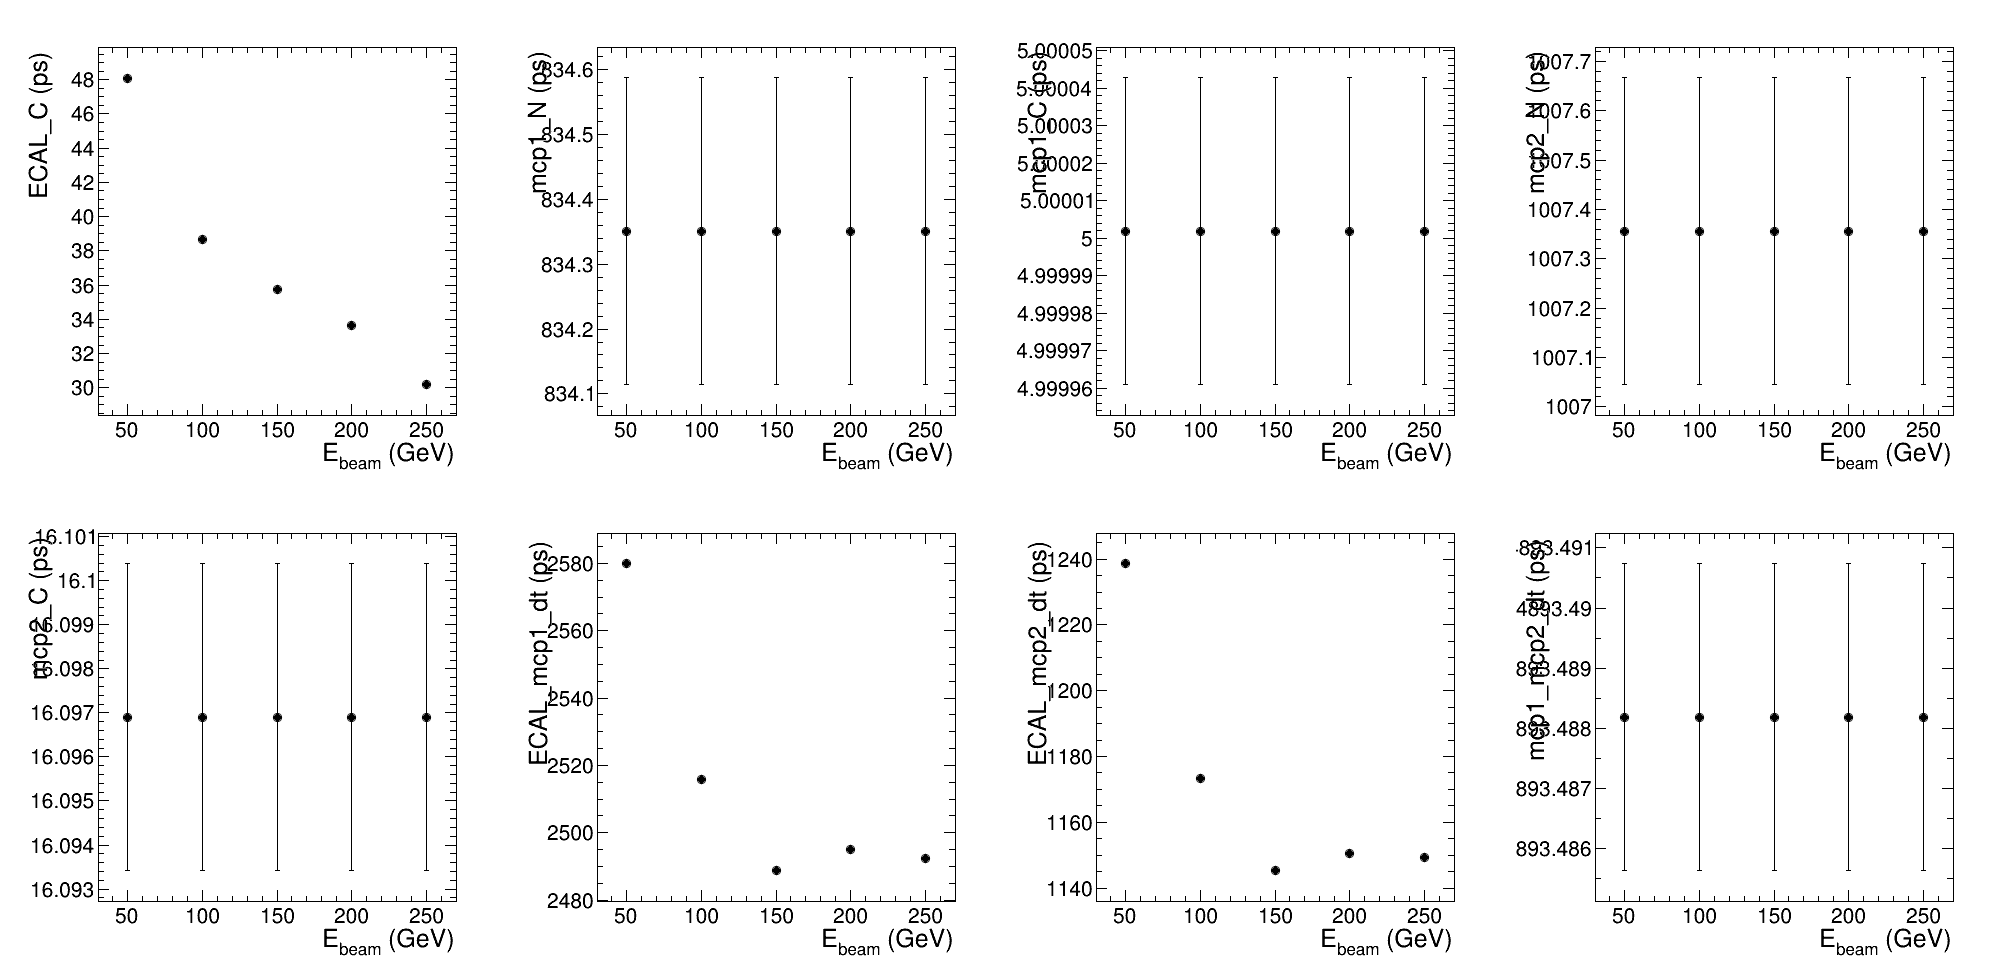

In [21]:
gr_params = []
for k, par in params_ecal.items():
    gr = ROOT.TGraphErrors()
    for i, e in enumerate(par.keys()):        
        gr.SetPoint(i, float(e), par[e][0])
        gr.SetPointError(i, 0, par[e][1])
        gr.SetTitle(";E_{beam} (GeV); %s (ps)"%k)
    gr_params.append(gr)
    
c = makeROOTCanvas(histos=gr_params, npads=(4,2), size=(2000,1000), drawopt='AP')
c.Draw()

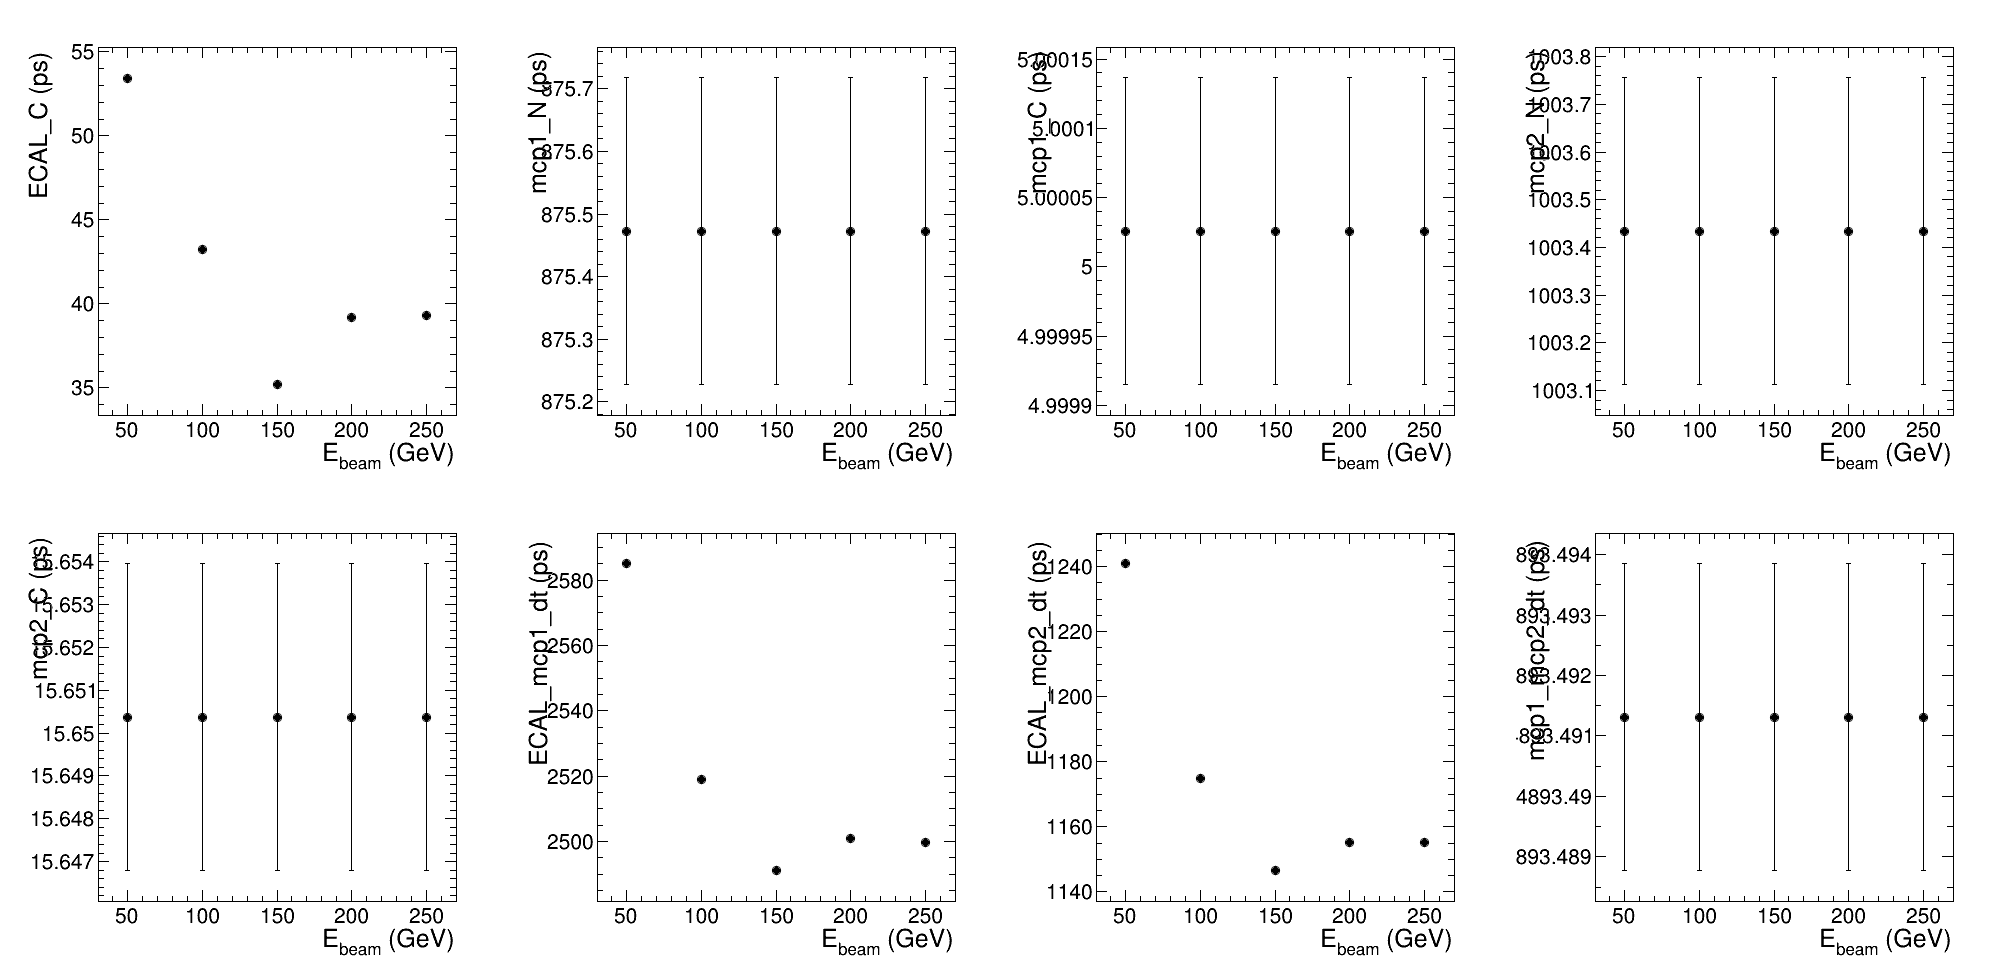

In [22]:
gr_params = []
for k, par in params_seed.items():
    gr = ROOT.TGraphErrors()
    for i, e in enumerate(par.keys()):        
        gr.SetPoint(i, float(e), par[e][0])
        gr.SetPointError(i, 0, par[e][1])
        gr.SetTitle(";E_{beam} (GeV); %s (ps)"%k)
    gr_params.append(gr)
    
c = makeROOTCanvas(histos=gr_params, npads=(4,2), size=(2000,1000), drawopt='AP')
c.Draw()

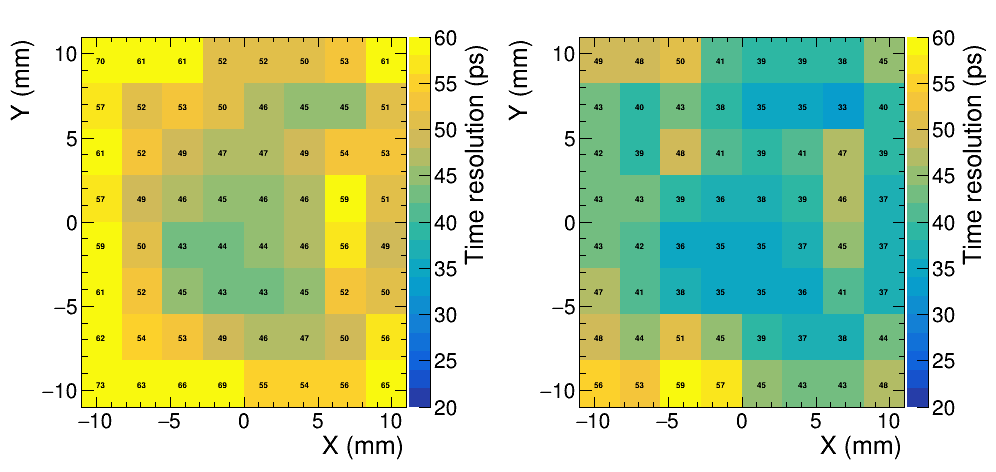

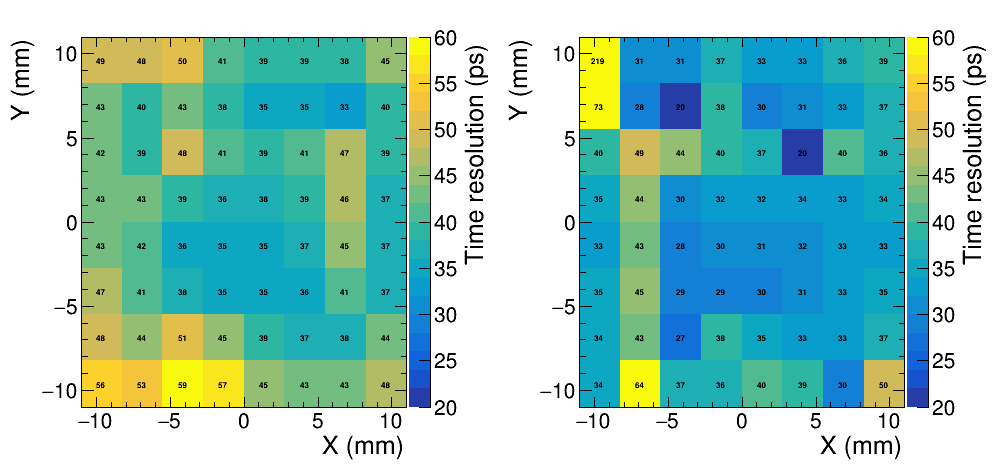

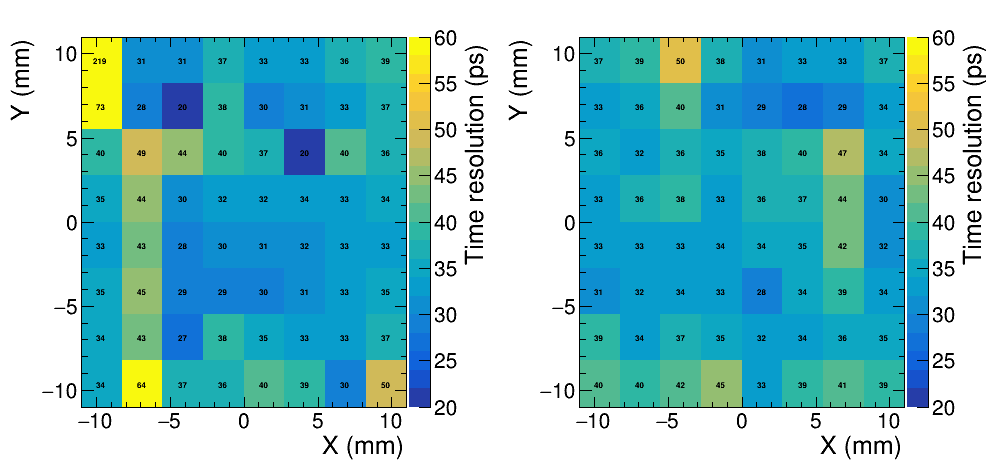

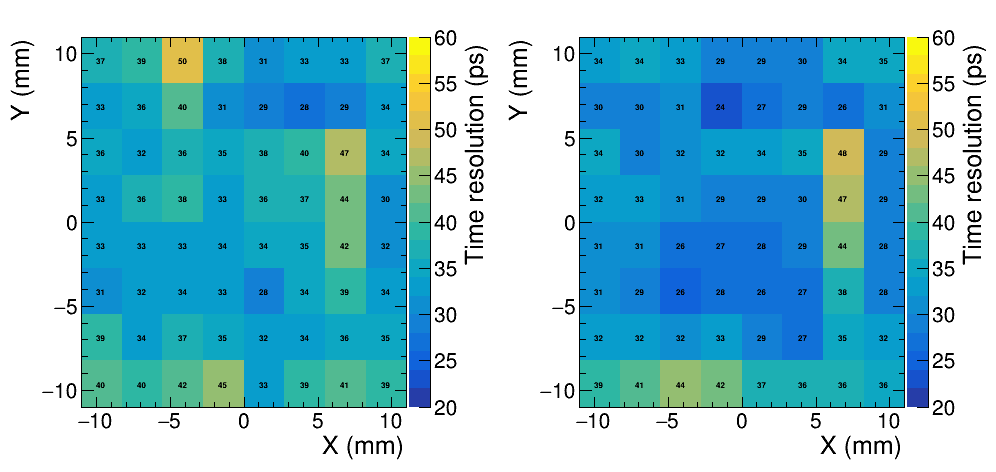

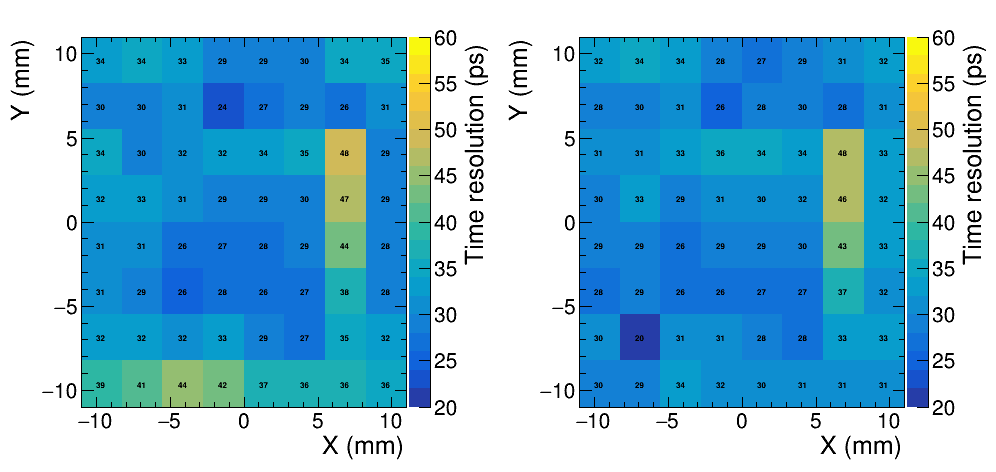

In [23]:
ROOT.gStyle.SetPaintTextFormat(".0f")

c = {}
res_map_seed = {}
res_map_ecal = {}
for E in energies:
    dt_map_seed[E].FitSlicesZ(f_res_t)
    res_map_seed[E] = deepcopy(ROOT.gDirectory.Get('dt_map_seed_%s_2'%E))
    res_map_seed[E].SetTitle(';X (mm); Y (mm); Time resolution (ps)')
    res_map_seed[E].Scale(1000.)
    res_map_seed[E].SetAxisRange(20, 60, "Z")
    res_map_seed[E].Draw("COLZTEXT")
    dt_map_ecal[E].FitSlicesZ(f_res_t)
    res_map_ecal[E] = deepcopy(ROOT.gDirectory.Get('dt_map_ecal_%s_2'%E))
    res_map_ecal[E].SetTitle(';X (mm); Y (mm); Time resolution (ps)')    
    res_map_ecal[E].Scale(1000.)    
    res_map_ecal[E].SetAxisRange(20, 60, "Z")
    
    c[E] = makeROOTCanvas(histos=[res_map_seed[E], res_map_ecal[E]], size=1000, drawopt='TEXTCOLZ')
    c[E].Draw()

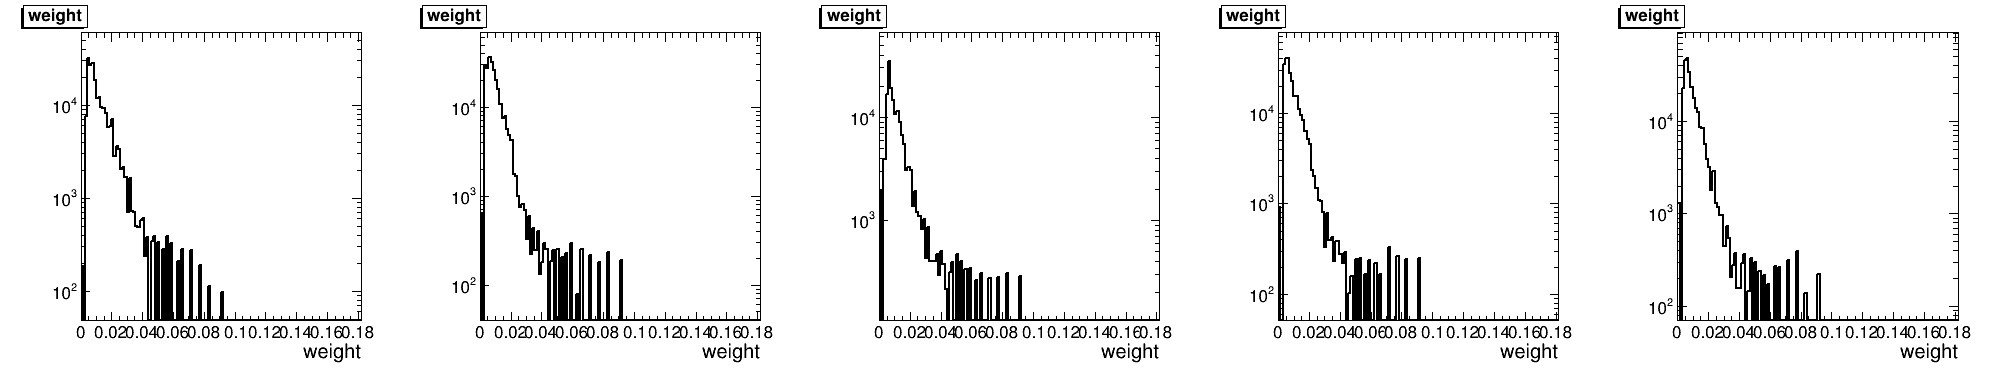

In [24]:
c = makeROOTCanvas(histos=h_weights.values(), size=2000)
for i in range(len(h_weights.values())):
    c.GetPad(i+1).SetLogy()
c.Draw()

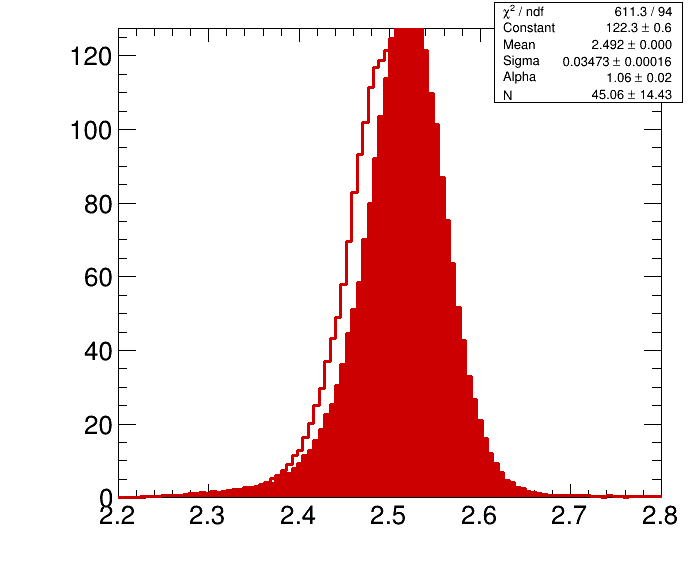

In [25]:
#h1 = selected_evts['100'].Histo1D(("h","",1000,2000,6000),"e3x3")
c = ROOT.TCanvas()
h_dt_mcp1_seed['150'].Draw("HIST")
h_dt_mcp1_seed['100'].SetFillStyle(4003)
h_dt_mcp1_seed['100'].Draw("HISTsame")
#c.SetLogy()
c.Draw()